# Testing ggwave (GibberLink Protocol)

In [1]:
import ggwave
import pyaudio
from scipy import signal

import matplotlib.pyplot as plt
import numpy as np
import pywt

In [2]:
channels = 1
rate = 48000
format = pyaudio.paFloat32
frames_per_buffer = 4096

### Getting Sound From Text

In [3]:
p = pyaudio.PyAudio()
text = 'hello Opticloud, tell us ideas to win the innovation challenge'
waveform = ggwave.encode(text, protocolId = 1, volume = 20) #bytes

print("Transmitting text ...")
stream = p.open(format=format, channels=channels, rate=rate, output=True, frames_per_buffer=frames_per_buffer)
stream.write(waveform, len(waveform)//4)
stream.stop_stream()
stream.close()

p.terminate()


Transmitting text ...


### Getting WavePlot

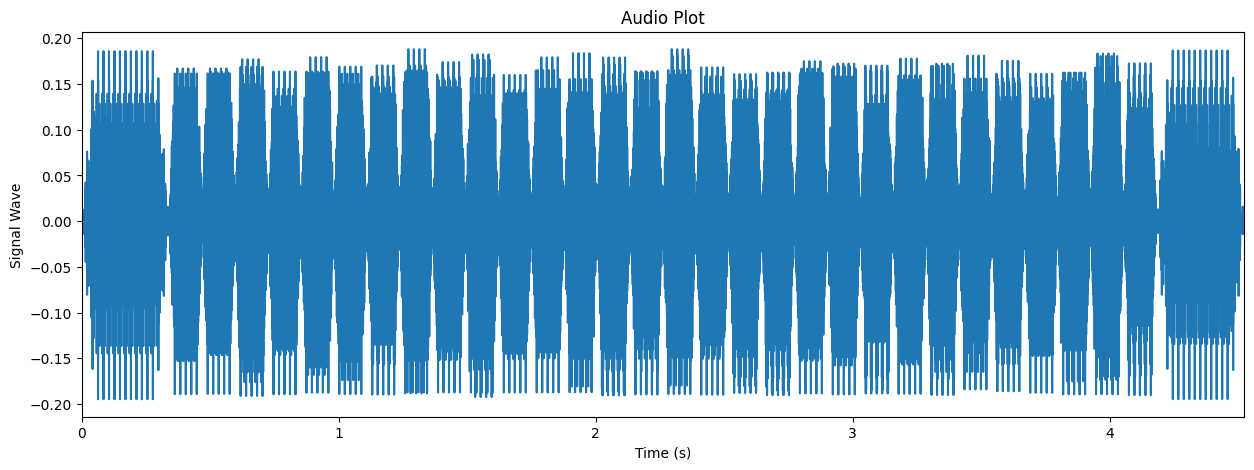

In [4]:

sample_freq = rate
width = p.get_sample_size(format)
frames = int(len(waveform) / (channels * width))
signal_wave = waveform

time = frames / sample_freq

audio_array = np.frombuffer(signal_wave, dtype=np.float32)

times = np.linspace(0, time, num=frames)

plt.figure(figsize=(15, 5))
plt.plot(times, audio_array)
plt.ylabel('Signal Wave')
plt.xlabel('Time (s)')
plt.xlim(0, time)
plt.title('Audio Plot')
plt.show()

### Getting Spectogram

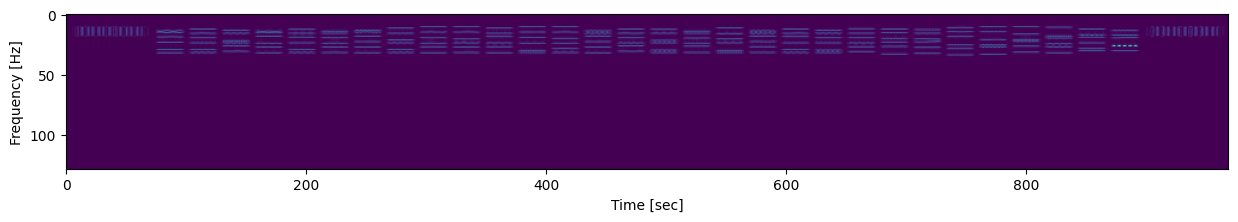

In [5]:
frequencies, times, spectrogram = signal.spectrogram(audio_array, rate)
f_max = sample_freq / 2 # Nyquist limit
plt.figure(figsize=(15, 5))
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### Spectogram Optimization

Component Decomposition

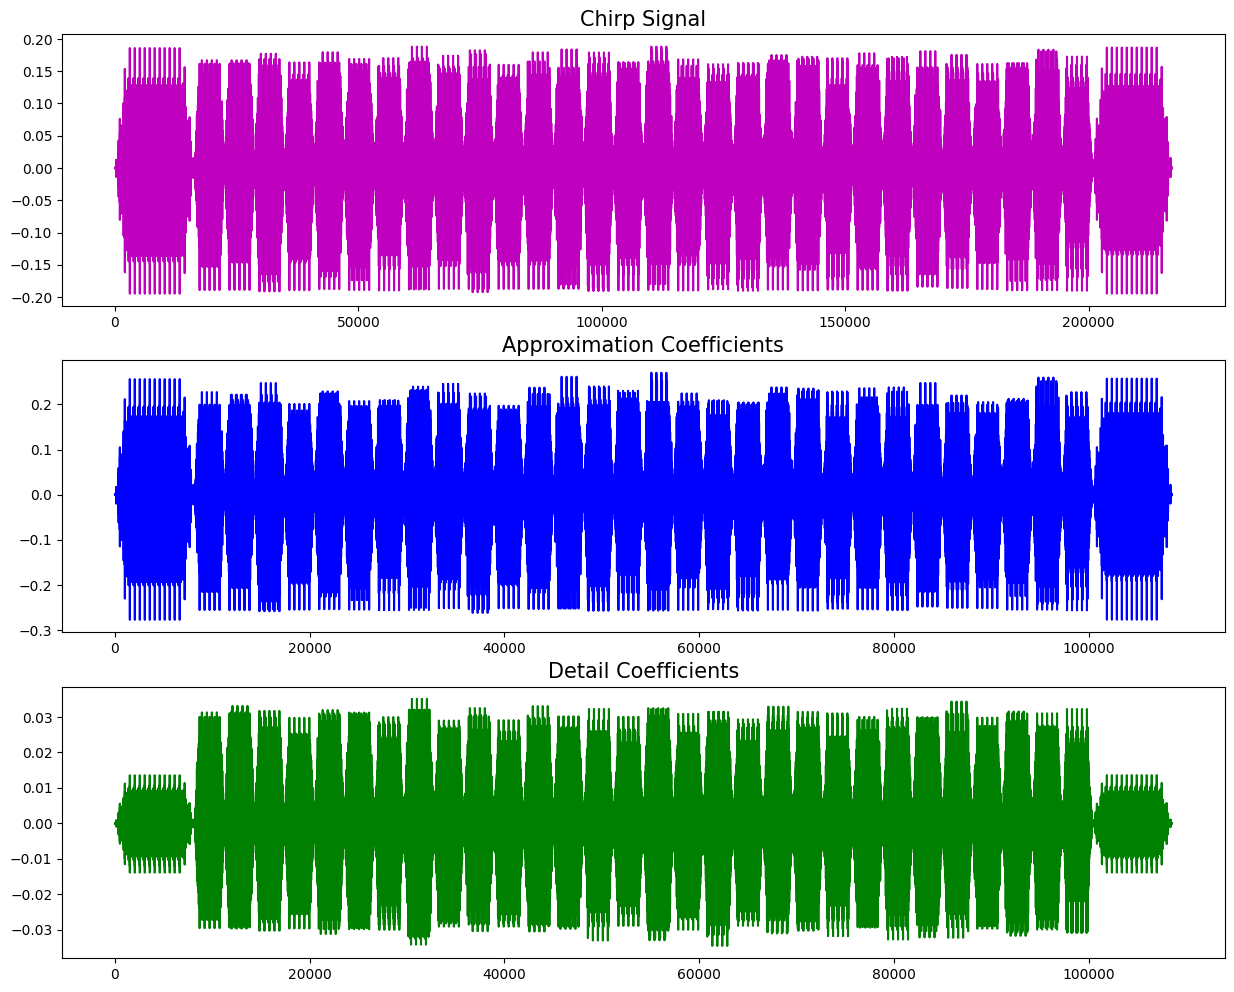

In [21]:
t = np.linspace(0, time, num=frames)
chirpSignal = np.copy(audio_array)
(cA,cD) = pywt.dwt(chirpSignal,'sym2',mode = 'symmetric')

plt.figure(figsize = (15,12))
plt.subplot(3,1,1)
plt.plot(chirpSignal, 'm')
plt.title("Chirp Signal", fontsize = 15)
plt.subplot(3,1,2)
plt.plot(cA, 'b')
plt.title("Approximation Coefficients", fontsize = 15)
plt.subplot(3,1,3)
plt.plot(cD, 'g')
plt.title("Detail Coefficients", fontsize = 15)
plt.show()

In [6]:
signal = np.copy(audio_array)

Cleaning noise with db4 

- best value for threshold is 0.2

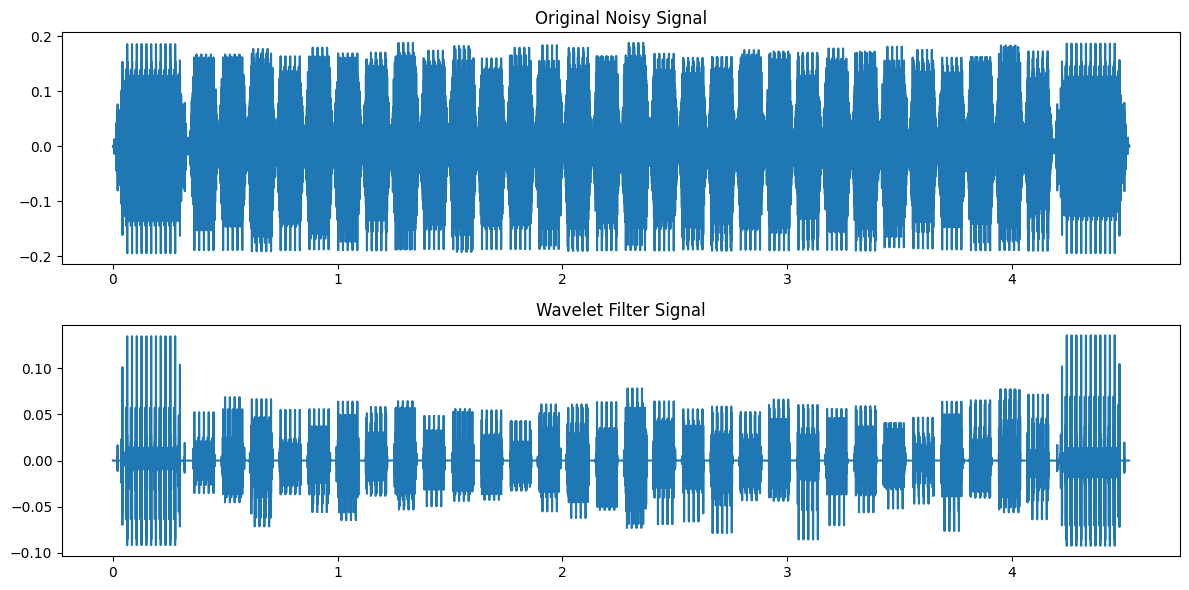

In [32]:

signal = np.copy(audio_array)
wavelet = 'db4'  # wavelet type
level = 5       
coeffs = pywt.wavedec(signal, wavelet, level=level)  # signal decomposition

threshold = 0.2 #
coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]  # threshold

filtered_signal = pywt.waverec(coeffs_thresh, wavelet)  # synal reconstruction

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Original Noisy Signal')

plt.subplot(2, 1, 2)
plt.plot(t, filtered_signal)
plt.title('Wavelet Filter Signal')

plt.tight_layout()
plt.show()


cleaning noise with sym4

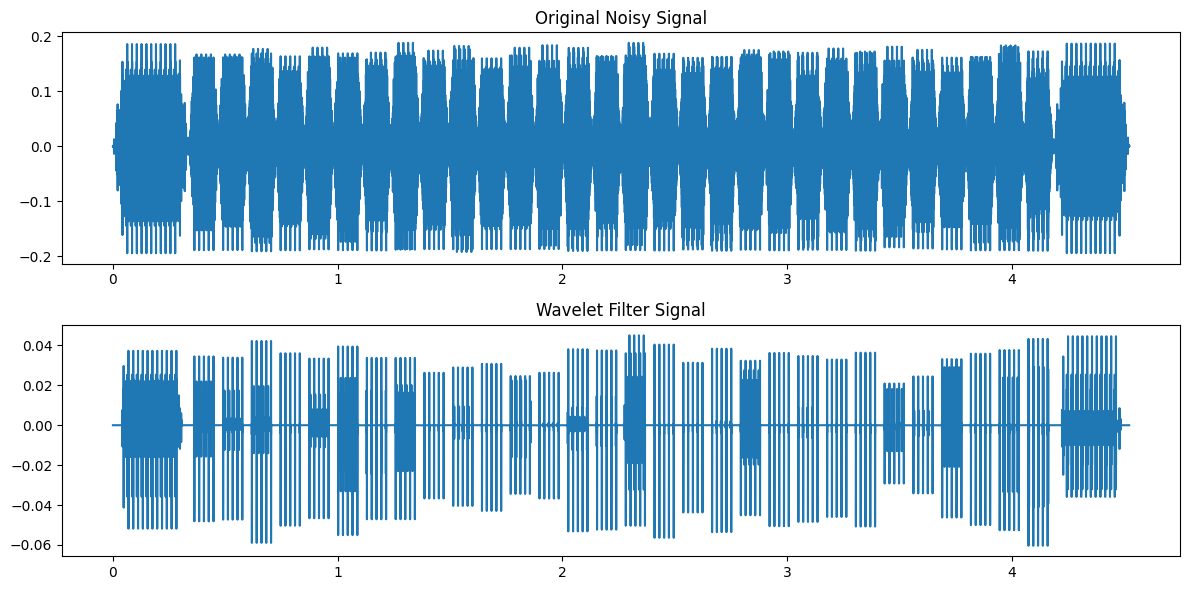

In [39]:

signal = np.copy(audio_array)
wavelet = 'sym4'  # wavelet type
level = 5       
coeffs = pywt.wavedec(signal, wavelet, level=level)  # signal decomposition

threshold = 0.3 
coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]  # threshold

filtered_signal = pywt.waverec(coeffs_thresh, wavelet)  # synal reconstruction

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Original Noisy Signal')

plt.subplot(2, 1, 2)
plt.plot(t, filtered_signal)
plt.title('Wavelet Filter Signal')

plt.tight_layout()
plt.show()


### Morl Wavelet

According to signals theory morl wavelete is good for our case: 

https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html


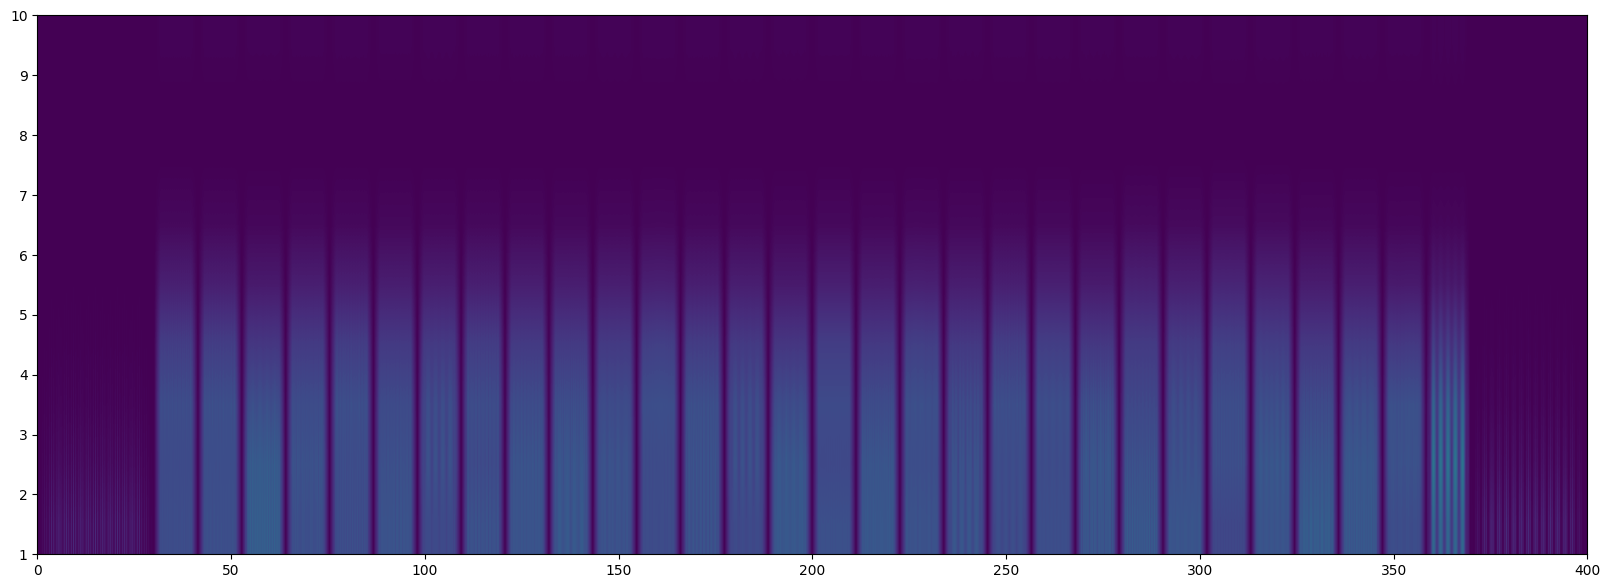

In [ ]:
coef,_ = pywt.cwt(signal, scales = np.arange(1,10), wavelet = 'morl')

plt.figure(figsize=(20, 7))
plt.imshow(abs(coef), extent=[0, 400, 1, 10], interpolation='bilinear', aspect='auto')
plt.yticks(np.arange(1, 11, 1))
plt.xticks(np.arange(0, 401, 10))
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Time Frequency Analysis', fontsize = 20)
plt.show()

#### Problem 1: 

Scale time between 0-1 ? can it be optional?

Seem like is good to keep original time, since Luquebel exploration found that too large prompts might guide an undesirable behavior and we might overlap different times 


#### Problem 2:

Automatically find the correct levels of frequency and time for a given signal

The range of scales from 1 to 127 covers a wide spectrum of frequencies, which is useful for signals with both low and high-frequency components.

- Scale 1: f = 0.8125 / 1.0001 = 812.5 Hz f = 1.0001 / 0.8125 = 812.5 Hz

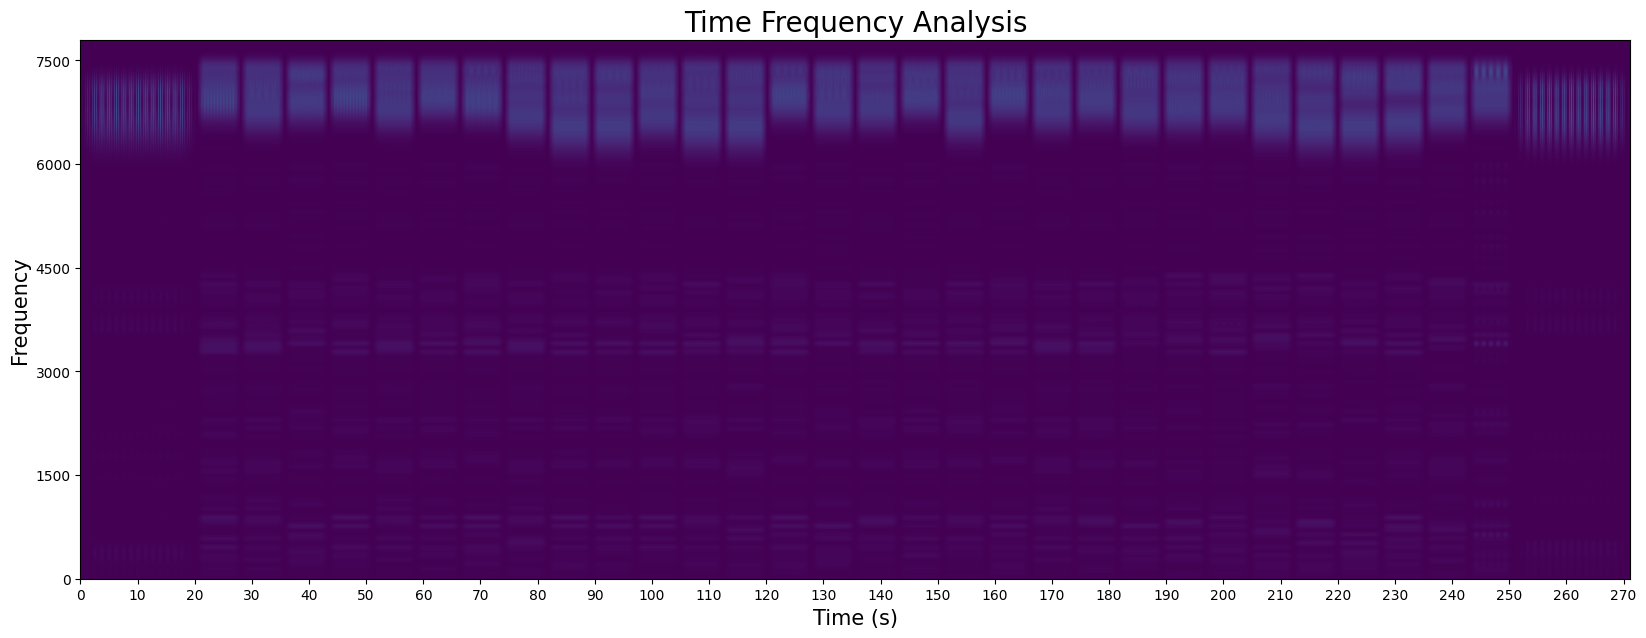

In [ ]:
max_seconds = round(t[-1],2)*60

f_min = 1000  
f_max = 3000 
f_c = 0.8125  
scales = np.arange(1, 128) 
max_scale = scales[-1]

coef, frequencies = pywt.cwt(signal, scales, 'morl', sampling_period=1/rate)

frequencies = f_c / (scales * (1/rate))

magnitude = np.abs(coef)
threshold = 0.1 * np.max(magnitude)  #  significative frequencies
significant_frequencies = frequencies[np.any(magnitude > threshold, axis=1)]

f_min_detected = np.min(significant_frequencies)
f_max_detected = np.max(significant_frequencies)


plt.figure(figsize=(20, 7))
plt.imshow(abs(coef), extent=[0, max_seconds, 0, f_max_detected], interpolation='bilinear', aspect='auto')
plt.yticks(np.arange(0, f_max_detected, 1500))
plt.xticks(np.arange(0, max_seconds, 10))
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Time Frequency Analysis', fontsize = 20)
plt.show()



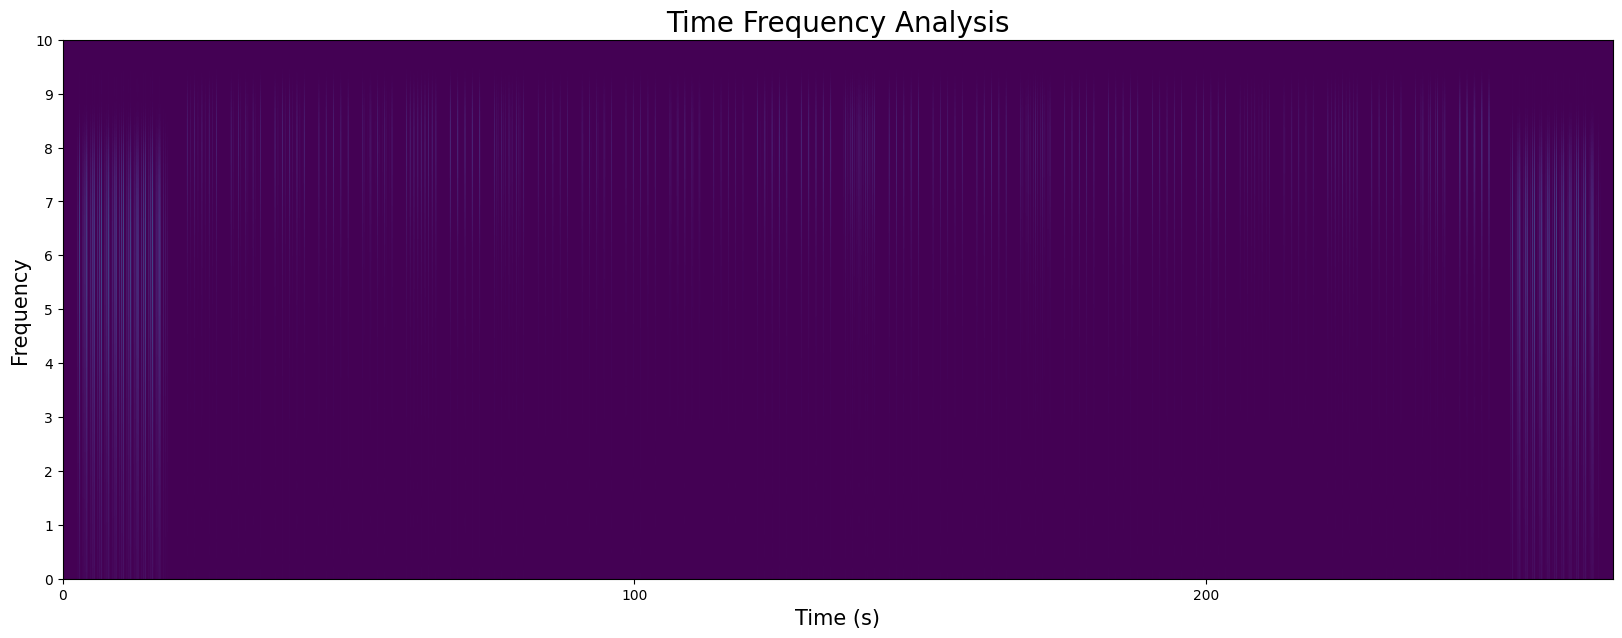

In [ ]:
max_seconds = round(t[-1],2)*60

f_min = 1000 
f_max = 3000 
f_c = 0.8125  
scales = np.arange(1, 50)  # scales for CWT


coef, frequencies = pywt.cwt(filtered_signal, scales, 'morl', sampling_period=1/rate)


plt.figure(figsize=(20, 7))
plt.imshow(abs(coef), extent=[0, max_seconds, 0, 10], interpolation='bilinear', aspect='auto')
plt.yticks(np.arange(0, 11, 1))
plt.xticks(np.arange(0, max_seconds+1, 100))
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Time Frequency Analysis', fontsize = 20)
plt.show()



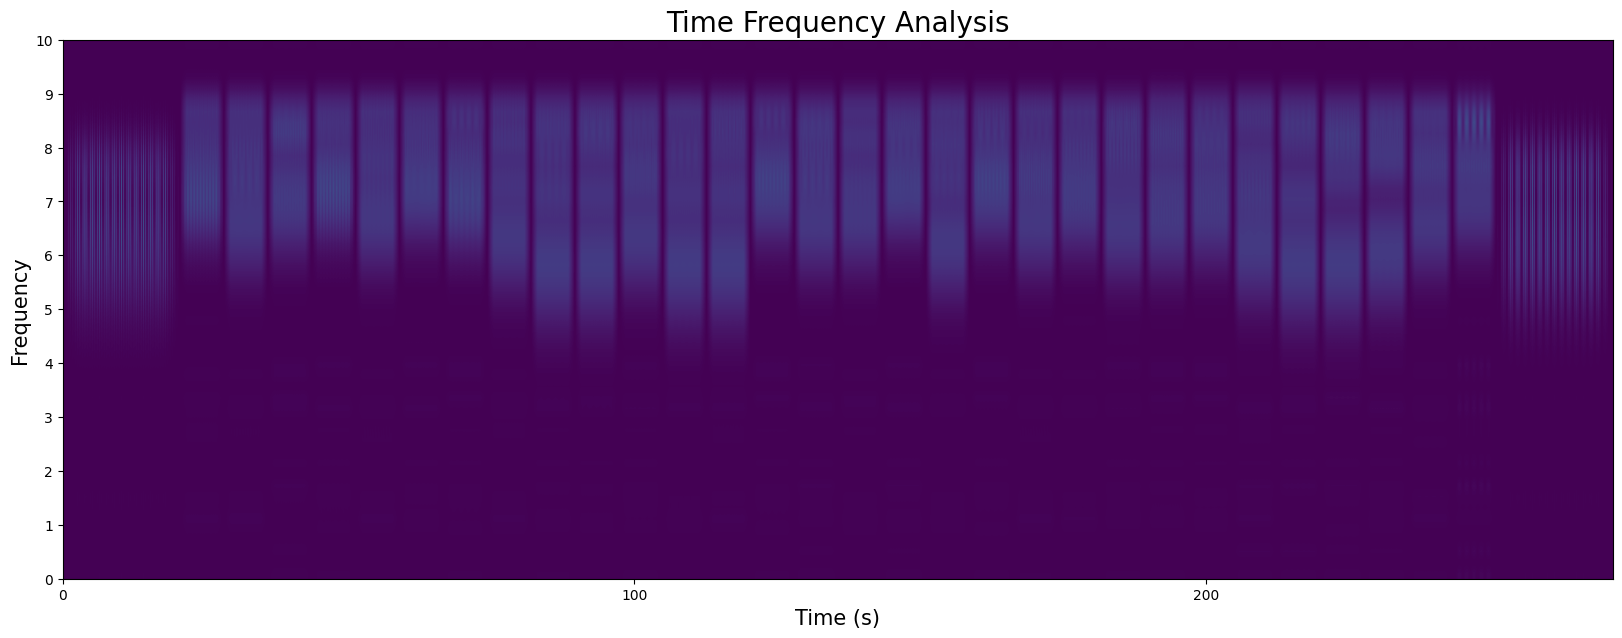

In [ ]:
max_seconds = round(t[-1],2)*60

f_min = 1000  # minimun frecuency (Hz)
f_max = 3000  # max frecuency (Hz)
f_c = 0.8125  # wavelet de Morlet central frequency
scales = np.arange(1, 50)  # scales for CWT


coef, frequencies = pywt.cwt(signal, scales, 'morl', sampling_period=1/rate)


plt.figure(figsize=(20, 7))
plt.imshow(abs(coef), extent=[0, max_seconds, 0, 10], interpolation='bilinear', aspect='auto')
plt.yticks(np.arange(0, 11, 1))
plt.xticks(np.arange(0, max_seconds+1, 100))
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Time Frequency Analysis', fontsize = 20)
plt.show()



#### **Conclusion**

According to creators: For all protocols: dF = 46.875 Hz. For non-ultrasonic protocols: F0 = 1875.000 Hz. For ultrasonic protocols: F0 = 15000.000 Hz.

- Is unclear how the protocol encode ultrasonic and non-ultrasonic tones, therefore it might be good to try max_frequency in the serie , but seems like using low scales to give more focus on high frequencies captures better the data. 

- Removing noisy isn't doing well as intense signals are important from the protocol and removing noise might end up with information lost.


- Spectogram looks good to test but other altenatives to take in consideration might include periodograms and density spectral analysis: 

https://www.geeksforgeeks.org/spectrum-analysis-in-python/#2-power-spectral-density-psd
